In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import gridspec
import ast
import os
os.chdir('/home/bojk/Data/') #this is when opened in '/home/bojk/Data/notebooks' on linux Quakelab
import sys
sys.path.append('/home/bojk/Data/minimeta_pyfiles/')
import imp
import HTSeq
from scipy.stats import powerlaw
#import minimetagenome_analysis as minimeta

import mock_metagenome_creation as mock
imp.reload(mock)
#import reassembly as rea
#import subcluster_bins as sub
#import checkm_out_plot as cop
#import checkm_out as co

import matplotlib as mpl
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15
mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['figure.titlesize'] = 18
mpl.rcParams['legend.fontsize'] = 14

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
maindir = "Mock/Archaea_illuminaHS_low<20contigs/"
kmerdf = pd.read_pickle(maindir+'stats/kmerdf__feb15.pickle')
contigdf = pd.read_pickle(maindir+'stats/contigdf__feb15.pickle')
statsdf = pd.read_pickle(maindir+'stats/statsdf__feb15.pickle')
tsne = pd.read_pickle(maindir+'stats/tsne_normalized_scaled_5mers_perp40.pickle')

kmerdf_norm = kmerdf.divide(contigdf['Sequence length'],axis=0)
kmer_pergenome = kmerdf_norm.join(tsne.genome).groupby('genome').sum()
kmer_pergenome = kmer_pergenome.divide(statsdf['frag_contigs'],axis=0)
# add genome-wide kmer variance to statsdf (normalized to genome with max variance)
statsdf['kmer_variance'] = kmer_pergenome.var(axis=1).divide(kmer_pergenome.var(axis=1).max())

In [3]:
meta = pd.read_pickle('Permafrost/FranklinBluffs/pickles/maindf_withDepth')
data = list(meta['Sequence Length'])
numbins = 100
bootstrap = 500
bins = np.logspace(3,6,numbins)
counts, bin_edges = np.histogram(data,bins=bins)

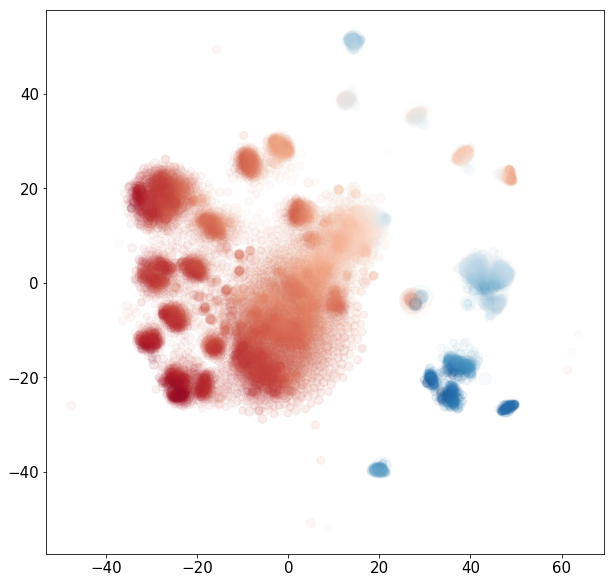

In [4]:
low_var_genome = statsdf[statsdf['kmer_variance']==statsdf['kmer_variance'].min()].index[0]
high_var_genome = statsdf[statsdf['kmer_variance']==statsdf['kmer_variance'].max()].index[0]
f,ax = plt.subplots(1,1,figsize=(10,10))
plt.scatter(tsne[0],tsne[1],s=tsne['Sequence length'].astype(float)/100,alpha=.05,c=tsne['GC'],cmap='RdBu_r')
f.savefig(maindir+'plots/tSNE_GC_5mer_feb_15.png')

In [ ]:
x = StandardScaler().fit_transform(kmerdf_norm)
pca = PCA(n_components=100)
principalComp = pca.fit_transform(x)
princdf = pd.DataFrame(principalComp)
princdf.index =tsne.index

x = StandardScaler().fit_transform(kmerdf_norm)
pca = PCA(n_components=2)
principalComp = pca.fit_transform(x)
princdf2 = pd.DataFrame(principalComp)
princdf2.index =tsne.index

In [ ]:
princdf.head()
#plt.yscale('log')

In [ ]:
princdf2.head()

In [ ]:
f,ax = plt.subplots(2,1,figsize=(8,7))
princdf.std().plot(ax=ax[0],linewidth=2)
plt.xlabel('PC')
ax[0].set_ylabel('Standard Deviation of PC')

# slope of the variance 
ax[1].plot(-np.log10(-np.gradient(princdf.std())))
ax[1].set_ylabel('-log$_{10}$ derivative')

In [ ]:
#tsne_PCA100, QC_PCA100 = make_tsne_from_df(princdf,contigdf,statsdf,maindir,'15feb_PCA100')

#tsne_PCA40, QC_PCA40 = make_tsne_from_df(princdf.loc[:,:39],contigdf,statsdf,maindir,'15feb_PCA40')
#tsne_PCA30, QC_PCA30 = make_tsne_from_df(princdf.loc[:,:29],contigdf,statsdf,maindir,'15feb_PCA30')
#tsne_PCA20, QC_PCA20 = make_tsne_from_df(princdf.loc[:,:19],contigdf,statsdf,maindir,'15feb_PCA20')
#tsne_PCA10, QC_PCA10 = make_tsne_from_df(princdf.loc[:,:9],contigdf,statsdf,maindir,'15feb_PCA10')

In [ ]:
imp.reload(mock)
tsne_PCA50, QC_PCA50 = mock.make_tsne_from_df(princdf.loc[:,:49],contigdf,statsdf,maindir,'15feb_PCA50')

In [ ]:
# how many clusters can we retrieve and what fraction of the genome do we retrieve?

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

def make_QCdf_from_tsnedf(tsnedf,maindir,savename):
    QC_df = pd.DataFrame(index=tsnedf.genome.unique(),columns=['distance','num_contigs'])
    for binn in QC_df.index:
        X = tsnedf[tsnedf.genome==binn][[0,1]]
        dist = euclidean_distances(X,X)
        distdf = pd.DataFrame(dist)
        medist = pd.DataFrame(index=range(len(dist)),columns=['medx','medy'])
        medist['medx']=X[0].median() #this is to compute distance to median
        medist['medy']=X[1].median()
        QC_df.loc[binn,'median_x'] = X[0].median()
        QC_df.loc[binn,'median_y'] = X[1].median()
        QC_df.loc[binn,'mean_x'] = X[0].mean()
        QC_df.loc[binn,'mean_y'] = X[1].mean()
        QC_df.loc[binn,'R_median'] =  pd.DataFrame(euclidean_distances(X,medist[['medx','medy']]))[0].median()
        QC_df.loc[binn,'R_mean'] = pd.DataFrame(euclidean_distances(X,medist[['medx','medy']]))[0].mean()
        QC_df.loc[binn,'distance'] = distdf.sum().sum()/2
        QC_df.loc[binn,'num_contigs'] = len(distdf)
    maxdist = np.max(euclidean_distances(tsnedf[[0,1]],tsnedf[[0,1]]))
    QC_df['mean_dist'] = QC_df['distance'].divide(QC_df['num_contigs']**2/2)
    QC_df['norm_mean_dist'] = QC_df['mean_dist'].divide(maxdist)
    QC_df.to_pickle(maindir+'QCdf_'+savename+'.pickle')
    return(QC_df)

In [ ]:
for i in [10,20,30,40,100]:
    savename = '15feb_PCA'+str(i)
    tsnedf = pd.read_pickle(maindir+'tsnedf_'+savename+'.pickle')
    make_QCdf_from_tsnedf(tsnedf,maindir,savename)

In [ ]:
f,ax =plt.subplots(figsize=(8,8))
kwds = dict(zip(['alpha','ax','label','s'],[.2,ax,None,40]))
tsne[tsne.genome!=high_var_genome].plot.scatter(0,1,c='gray',**kwds)
tsne[tsne.genome==high_var_genome].plot.scatter(0,1,**kwds)
meanx = tsne[tsne.genome==high_var_genome][0].mean()
meany = tsne[tsne.genome==high_var_genome][1].mean()
medx = tsne[tsne.genome==high_var_genome][0].median()
medy = tsne[tsne.genome==high_var_genome][1].median()
ax.scatter(meanx,meany,s=100,c='m',label='mean center')
ax.scatter(medx,medy,s=100,c='orange',label='median center')
plt.legend()

In [ ]:
meanx

In [ ]:
#euclidean_distances(X[0].median(),X.iloc[0,0])
dist = euclidean_distances(X,X)
pd.DataFrame(dist)
medist = pd.DataFrame(index=range(len(dist)),columns=['medx','medy'])
medist['medx']=X[0].median()
medist['medy']=X[1].median()
pd.DataFrame(euclidean_distances(X,medist[['medx','medy']]))[0].mean()


In [ ]:
imp.reload(mock)
QC_PCA40 = pd.read_pickle(maindir+'QCdf_15feb_PCA40.pickle')
QC_PCA50 = make_QCdf_from_tsnedf(tsne_PCA50,maindir,'15feb_PCA50')

In [ ]:
dat = QC_PCA50.iloc[0]
x,y = circle(dat['median_x'],dat['median_y'],dat['R_median'])

In [ ]:
def circle(x,y,r):
    t = np.arange(0,2*np.pi,.01)
    cx = x+r*np.sin(t)
    cy = y+r*np.cos(t)
    return(cx,cy)

In [ ]:
x,y = circle(dat['median_x'],dat['median_y'],dat['R_median'])
x2,y2 = circle(dat['median_x'],dat['median_y'],dat['R_mean'])
f,ax = plt.subplots(figsize=(8,8))
tsne_PCA50[tsne_PCA50.genome!=dat.name].plot.scatter(0,1,alpha=.05,s=tsne_PCA50['Sequence length'].astype(float).divide(2e2),c='gray',ax=ax,label=None)
tsne_PCA50[tsne_PCA50.genome==dat.name].plot.scatter(0,1,alpha=.2,s=tsne_PCA50['Sequence length'].astype(float).divide(2e2),c='orange',ax=ax,label='genome '+dat.name)
plt.plot(dat['median_x'],dat['median_y'],'o',label='median contig pos')
plt.plot(dat['mean_x'],dat['mean_y'],'or',label='mean contig pos')
plt.plot(x,y,label='R=median dist')
plt.plot(x2,y2,label='R=mean dist')
plt.legend(bbox_to_anchor=(1.5, 1), loc='upper right')

In [ ]:
f,ax = plt.subplots(figsize=(8,8))
tsne_PCA50[tsne_PCA50.genome!=dat.name].plot.scatter(0,1,alpha=.05,s=tsne_PCA50['Sequence length'].astype(float).divide(2e2),c='gray',ax=ax,label=None)
tsne_PCA50[tsne_PCA50.genome==dat.name].plot.scatter(0,1,alpha=.2,s=tsne_PCA50['Sequence length'].astype(float).divide(2e2),c='orange',ax=ax,label='genome '+dat.name)
plt.plot([QC_PCA50['median_x'],QC_PCA50['mean_x']],[QC_PCA50['median_y'],QC_PCA50['mean_y']],'-om',label='median contig pos')
plt.plot(QC_PCA50['median_x'],QC_PCA50['median_y'],'o',label='median contig pos')
plt.plot(QC_PCA50['mean_x'],QC_PCA50['mean_y'],'or',label='mean contig pos')
c1,c2 = circle(0,0,65)
plt.plot(c1,c2,'k')

plt.plot(x,y,label='R=median dist')
plt.plot(x2,y2,label='R=mean dist')
plt.plot(0,0,'ok')
#plt.legend(bbox_to_anchor=(1.5, 1), loc='upper right')

In [ ]:
QC_PCA50['R_mean'].divide(QC_PCA50['R_median']).plot()
#plt.yscale('log')

In [ ]:
QC_PCA50['R_median'].divide(QC_PCA50['R_mean']).plot()
plt.ylim(0,1)

In [ ]:
imp.reload(mock)
#QC_PCA50 = mock.make_QCdf_from_tsnedf(tsne_PCA50,maindir,'15feb_PCA50')
QC_main_tsne = mock.make_QCdf_from_tsnedf(tsne,maindir,'15feb_maintSNE')

In [ ]:
QC_main_tsne.head()

In [ ]:
max_dist_from_origin = QC_PCA50['dist_from_origin_median'].max()
cx,cy = circle(0,0,max_dist_from_origin)
f,ax = plt.subplots(figsize=(12,12))
tsne_PCA50.plot.scatter(0,1,alpha=.5,s=tsne_PCA50['Sequence length'].astype(float).divide(2e2),
                     c='gray',ax=ax,label=None)
plt.plot(cx,cy,'k')
plt.plot(0,0,'ok')
plt.plot([QC_PCA50['median_x'],QC_PCA50['mean_x']],
         [QC_PCA50['median_y'],QC_PCA50['mean_y']],
         '-om',label='median contig pos')
plt.show()

In [ ]:
# check for overlap
# flag any ground truths with median distance closer to each other than median/mean radii
mock.plot_all_circles(tsne_PCA50,QC_PCA50,maindir+'plots/','15feb_PCA50')

In [ ]:
mock.plot_all_circles_thres(tsne_PCA50,QC_PCA50,.8,maindir+'plots/','15feb_PCA50')

In [ ]:
# colored if non-overlapping (median radii)
mock.plot_all_circles_nonOverlap(tsne_PCA50,QC_PCA50,maindir+'plots/','15feb_PCA50')

In [ ]:
imp.reload(mock)
QC_main_tsne = mock.make_QCdf_from_tsnedf(tsne,maindir,'15feb_maintSNE')
mock.plot_all_circles_nonOverlap(tsne,QC_main_tsne,maindir+'plots/','15feb_maintSNE')

In [ ]:
tsne = pd.read_pickle(maindir+'stats/tsne_normalized_scaled_5mers_perp40.pickle')

In [ ]:
imp.reload(mock)
keys = ['min_cluster_size','min_samples','cluster_selection_method','allow_single_cluster',
       'expt_name']
values = [round(145*.8),1,'leaf',True,'15feb_maintSNE']
kwargs = dict(zip(keys,values))
tsne,stats = mock.cluster_main_tsne(tsne,maindir,**kwargs)

In [ ]:
statsdf.sort_values('frag_contigs')

In [ ]:
#center mess genomes
center_genomes = ['2636416047','2510065051','2636416021','2517287024','2639762563']
statsdf.loc[center_genomes]

In [ ]:

f,ax = plt.subplots(figsize=(5,5))
bins=np.linspace(0.5,0.7,40)
for genome in center_genomes:
    contigdf[contigdf.index.str.contains(genome)]['GC'].plot.density()
plt.xlim(0.42,0.7)
plt.xlabel('GC-content')
f.savefig(maindir+'plots/GC-density_centerNonClusteringGenomes.png')

In [ ]:
f,ax = plt.subplots(figsize=(10,10))
bins=np.linspace(0.5,0.7,40)
for genome in statsdf.index:
    contigdf[contigdf.index.str.contains(genome)]['GC'].plot.density()
plt.xlim(0.2,0.8)

In [ ]:
savename = '15feb_PCA'+str(10)
tsnedf_PCA10 = pd.read_pickle(maindir+'tsnedf_'+savename+'.pickle')
QC_PCA10 =  mock.make_QCdf_from_tsnedf(tsnedf_PCA10,maindir,savename)
mock.plot_all_circles_nonOverlap(tsnedf_PCA10,QC_PCA10,maindir+'plots/',savename)

In [ ]:
savename = '15feb_PCA'+str(20)
tsnedf_PCA20 = pd.read_pickle(maindir+'tsnedf_'+savename+'.pickle')
QC_PCA20 =  mock.make_QCdf_from_tsnedf(tsnedf_PCA20,maindir,savename)
mock.plot_all_circles_nonOverlap(tsnedf_PCA20,QC_PCA20,maindir+'plots/',savename)

In [ ]:
savename = '15feb_PCA'+str(40)
tsnedf_PCA40 = pd.read_pickle(maindir+'tsnedf_'+savename+'.pickle')
QC_PCA40 =  mock.make_QCdf_from_tsnedf(tsnedf_PCA40,maindir,savename)
mock.plot_all_circles_nonOverlap(tsnedf_PCA40,QC_PCA40,maindir+'plots/',savename)

In [ ]:
savename = '15feb_PCA'+str(100)
tsnedf_PCA100 = pd.read_pickle(maindir+'tsnedf_'+savename+'.pickle')
QC_PCA100 =  mock.make_QCdf_from_tsnedf(tsnedf_PCA100,maindir,savename)
mock.plot_all_circles_nonOverlap(tsnedf_PCA100,QC_PCA100,maindir+'plots/',savename)

In [ ]:
QC_main_tsne['QS'] = QC_main_tsne['frac_median_orig']*(1-QC_main_tsne['norm_mean_dist'])*QC_main_tsne['NN_dist_norm']

In [ ]:
QC_main_tsne['QS_rank'] = QC_main_tsne.rank(axis=0,ascending=False)['QS']

In [ ]:
idx = QC_main_tsne.sort_values('QS').index
QC_main_tsne.sort_values('QS')['QS'].plot(label='orig')
QC_PCA10.loc[idx,'QS'].plot(label='PC10')
QC_PCA20.loc[idx,'QS'].plot(label='PC20')
QC_PCA40.loc[idx,'QS'].plot(label='PC40')
QC_PCA100.loc[idx,'QS'].plot(label='PC100')
plt.legend()
plt.yscale('log')

In [ ]:
idx = QC_main_tsne.sort_values('QS').index
QC_main_tsne.sort_values('QS')['QS'].plot(label='orig')
QC_PCA10.sort_values('QS')['QS'].plot(label='PC10')
QC_PCA20.sort_values('QS')['QS'].plot(label='PC20')
QC_PCA40.sort_values('QS')['QS'].plot(label='PC40')
QC_PCA100.sort_values('QS')['QS'].plot(label='PC100')
plt.legend()
plt.yscale('log')
plt.xticks([])
plt.xlabel('Ranked genomes')

In [ ]:
ind = np.logspace(-3,0,500)
#ind = 1000

In [ ]:
bw=.25
f,ax = plt.subplots(figsize=(7,5))
QC_main_tsne['QS'].plot.density(ind=ind,label='5mer',bw_method=bw)
QC_PCA10['QS'].plot.density(ind=ind,label='10PCs',bw_method=bw)
QC_PCA20['QS'].plot.density(ind=ind,label='20PCs',bw_method=bw)
QC_PCA40['QS'].plot.density(ind=ind,label='40PCs',bw_method=bw)
QC_PCA100['QS'].plot.density(ind=ind,label='100PCs',bw_method=bw)
plt.legend()
#plt.xscale('log')
plt.xlabel('Quality Score')
plt.xlim(0,.5)

In [ ]:
tsne[tsne.genome=='2636416021'].groupby('Bin').count()[0]

In [ ]:
tsne
matrix = pd.DataFrame(index=tsne.Bin.unique(),columns=tsne.genome.unique())
for genome in matrix.columns:
    matrix[genome] = tsne[tsne.genome==genome].groupby('Bin').count()[0]

In [ ]:
genome_centric = matrix.divide(matrix.sum())

In [ ]:
cluster_centric = matrix.T.divide(matrix.sum(axis=1))

In [ ]:
cluster_centric.max().sort_values().plot(style='-o')
plt.xticks([])
plt.xlabel('Clusters')
plt.ylabel('Largest single-genome fraction')

In [ ]:
genome_centric.max().sort_values().plot(style='-o')
plt.xticks([])
plt.xlabel('Genomes')
plt.ylabel('Largest single-cluster fraction')

In [ ]:
# adjusted rand index
# make columns for true and predicted labels
# true_labels = range(#genomes)
# predicted_labels: equals true label for cluster with largest number of true? 

# or homogeneity, completeness, v_measure
"""# homogeneity:
for genome in matrix.columns:
    temp = matrix[genome].dropna()
    for cluster in temp.index:

for genome in matrix.columns:
"""
n = matrix.sum().sum()
ncn = matrix.T.sum(axis=1).divide(n)
HC = -np.sum(ncn*np.log(ncn))
nkn= matrix.sum(axis=1).divide(n)
HK = -np.sum(nkn*np.log(nkn))

In [ ]:
def homogeneity(matrix):
    n = matrix.sum().sum()
    ncn = matrix.T.sum(axis=1).divide(n)
    HC = -np.sum(ncn*np.log(ncn))
    nk = matrix.T.sum()
    HCK = 0
    for genome in matrix.columns:
        nc = -np.sum(matrix[genome].divide(n)*np.log(matrix[genome].divide(nk)))
        HCK = HCK+nc
    homogeneity=1-HCK/HC
    return homogeneity

def completeness(matrix):
    n = matrix.sum().sum()
    nkn= matrix.sum(axis=1).divide(n)
    HK = -np.sum(nkn*np.log(nkn))
    nc = matrix.sum()
    HKC = 0
    for cluster in matrix.index:
        nk = -np.sum(matrix.T[cluster].divide(n)*np.log(matrix.T[cluster].divide(nc)))
        HKC = HKC+nk
    completeness = 1-HKC/HK
    return completeness

In [ ]:
nk = matrix.T.sum()
HCK = 0
for genome in matrix.columns:
    nc = -np.sum(matrix[genome].divide(n)*np.log(matrix[genome].divide(nk)))
    HCK = HCK+nc
HCK
homogeneity=1-HCK/HC
homogeneity

In [ ]:
nc = matrix.sum()
HKC = 0
for cluster in matrix.index:
    nk = -np.sum(matrix.T[cluster].divide(n)*np.log(matrix.T[cluster].divide(nc)))
    HKC = HKC+nk
HKC
completeness = 1-HKC/HK
completeness

In [ ]:

v_measure = 2*h*c/(h+c)

In [ ]:
def cluster_quality(tsne,maindir,savename):
    matrix = pd.DataFrame(index=tsne.Bin.unique(),columns=tsne.genome.unique())
    for genome in matrix.columns:
        matrix[genome] = tsne[tsne.genome==genome].groupby('Bin').count()[0]
    matrix.drop('-01',inplace=True)
    genome_centric = matrix.divide(matrix.sum())
    cluster_centric = matrix.T.divide(matrix.sum(axis=1))
    
    homogen = homogeneity(matrix)
    complet = completeness(matrix)
    v_measure = 2*homogen*complet/(homogen+complet)
    
    f,ax = plt.subplots(1,2,figsize=(10,5))
    cluster_centric.max().sort_values().plot(style='-o',ax=ax[0])
    ax[0].set_xticks([])
    ax[0].set_xlabel('Clusters')
    ax[0].set_ylabel('Largest single-genome fraction')
    
    genome_centric.max().sort_values().plot(style='-o',ax=ax[1])
    ax[1].set_xticks([])
    ax[1].set_xlabel('Genomes')
    ax[1].set_ylabel('Largest single-cluster fraction')
    f.savefig(maindir+'plots/'+savename+'_cluster_qual.png')
    
    return(homogen,complet,v_measure)
    
    


In [ ]:
h_main,c_main,v_main = cluster_quality(tsne,maindir,'maintSNE_hdbleaf')

In [ ]:
h_main
c_main
v_main

In [ ]:
imp.reload(mock)
keys = ['min_cluster_size','min_samples','cluster_selection_method','allow_single_cluster',
       'expt_name']
values = [round(145*.8),1,'leaf',True,'15feb_maintSNE_leaf80pct']
kwargs = dict(zip(keys,values))
tsne,stats,QCl = mock.cluster_main_tsne(tsne,maindir,**kwargs)
print(QCl)

In [ ]:
imp.reload(mock)
keys = ['min_cluster_size','min_samples','cluster_selection_method','allow_single_cluster',
       'expt_name']
values = [round(145*.8),1,'eom',True,'15feb_maintSNE_eom80pct']
kwargs = dict(zip(keys,values))
tsne,stats,QCm = mock.cluster_main_tsne(tsne,maindir,**kwargs)
print(QCm)

In [ ]:
QCm.append(QCm)

In [ ]:
leafdf = pd.DataFrame(index=[int(f) for f in np.linspace(.1,2,20)*1e2],columns=['hom_leaf','com_leaf','val_leaf']) 

In [ ]:
leafdf.loc[10]=QCm

In [ ]:
leafdf

In [ ]:
imp.reload(mock)
clust_qual = mock.minCS_sweep(tsne,maindir,'main_tSNE_sweep','15feb_maintSNE')

In [ ]:
clust_qual

In [ ]:
clust_qual['val_leaf'].plot(style='-o')
clust_qual['val_eom'].plot(style='-o')
clust_qual['hom_leaf'].plot(style='-o',label='leaf_hom')
clust_qual['hom_eom'].plot(style='-o',label='eom_hom')
clust_qual['com_leaf'].plot(style='-o',label='leaf_comp')
clust_qual['com_eom'].plot(style='-o',label='eom_comp')
plt.legend()

In [ ]:
imp.reload(mock)
clust_qual_PC50 = mock.minCS_sweep(tsne_PCA50,maindir,'PCA50_sweep','15feb_PCA50')
clust_qual_PC50['val_leaf'].plot(style='-o')
clust_qual_PC50['val_eom'].plot(style='-o')

In [ ]:
clust_qual['val_leaf'].plot(style='-o',label='5mers')
clust_qual_PC50['val_leaf'].plot(style='-o',label='50PCs')
plt.legend()

In [ ]:
tsne_PCA2 = pd.read_pickle(maindir+'tsnedf_15feb_PCA2.pickle')
tsne_PCA10 = pd.read_pickle(maindir+'tsnedf_15feb_PCA10.pickle')
tsne_PCA20 = pd.read_pickle(maindir+'tsnedf_15feb_PCA20.pickle')
tsne_PCA30 = pd.read_pickle(maindir+'tsnedf_15feb_PCA30.pickle')
tsne_PCA40 = pd.read_pickle(maindir+'tsnedf_15feb_PCA40.pickle')
tsne_PCA100 = pd.read_pickle(maindir+'tsnedf_15feb_PCA100.pickle')

In [ ]:
clust_qual_PC2 = mock.minCS_sweep(tsne_PCA2,maindir,'PCA2_sweep','15feb_PCA2')
clust_qual_PC10 = mock.minCS_sweep(tsne_PCA10,maindir,'PCA10_sweep','15feb_PCA10')
clust_qual_PC20 = mock.minCS_sweep(tsne_PCA20,maindir,'PCA20_sweep','15feb_PCA20')
clust_qual_PC30 = mock.minCS_sweep(tsne_PCA30,maindir,'PCA30_sweep','15feb_PCA30')
clust_qual_PC40 = mock.minCS_sweep(tsne_PCA40,maindir,'PCA40_sweep','15feb_PCA40')
clust_qual_PC100 = mock.minCS_sweep(tsne_PCA100,maindir,'PCA100_sweep','15feb_PCA100')

In [ ]:
clust_qual['val_leaf'].plot(style='-o',label='5mers')
clust_qual_PC2['val_leaf'].plot(style='-o',label='2PCs')
clust_qual_PC10['val_leaf'].plot(style='-o',label='10PCs')
clust_qual_PC20['val_leaf'].plot(style='-o',label='20PCs')
clust_qual_PC30['val_leaf'].plot(style='-o',label='30PCs')
clust_qual_PC40['val_leaf'].plot(style='-o',label='40PCs')
clust_qual_PC50['val_leaf'].plot(style='-o',label='50PCs')
clust_qual_PC100['val_leaf'].plot(style='-o',label='100PCs')
plt.legend(bbox_to_anchor=(1.5, 1), loc='upper right')

In [ ]:
if not os.path.isdir(maindir+subfolder):
    os.mkdir(maindir+subfolder)

In [ ]:
clust_qual['val_eom'].plot(style='-o',label='5mers')
clust_qual_PC2['val_eom'].plot(style='-o',label='2PCs')
clust_qual_PC10['val_eom'].plot(style='-o',label='10PCs')
clust_qual_PC20['val_eom'].plot(style='-o',label='20PCs')
clust_qual_PC30['val_eom'].plot(style='-o',label='30PCs')
clust_qual_PC40['val_eom'].plot(style='-o',label='40PCs')
clust_qual_PC50['val_eom'].plot(style='-o',label='50PCs')
clust_qual_PC100['val_eom'].plot(style='-o',label='100PCs')
plt.legend(bbox_to_anchor=(1.5, 1), loc='upper right')

In [ ]:
# find max of 
class Metagenome_contigs:
    def __init__(self, kmerdf,contigdf,statsdf):
        self.kmer_frequencies = kmerdf
        self.contigs = contigdf
        self.genome_stats = statsdf

class Dimensional_reduction:
    def __init__(self,numdims,tsnedf,QCdf,HDBqualdf):
        self.number_of_dimensions_reduced = numdims
        self.main_tsne = tsnedf
        self.HDBscan_performance = HDBqualdf
        self.dimensional_reduction_quality = QCdf




In [ ]:
a = MyClass(tsne,contigdf,statsdf)
b = MyClass(tsne)

In [ ]:
a = Dimensional_reduction(1024,tsne,QC_main_tsne,clust_qual)

In [ ]:
a.number_of_dimensions_reduced


In [ ]:
clust_qual['val_leaf'].max()

In [ ]:
clust_qual['val_leaf'].idxmax()

In [ ]:
def get_max_pos(df):
    df = df.astype(float)
    m = df['val_leaf'].max()
    i = df['val_leaf'].idxmax()
    return m,i

opt_mai = get_max_pos(clust_qual)
opt_pc2 = get_max_pos(clust_qual_PC2)
opt_p10 = get_max_pos(clust_qual_PC10)
opt_p20 = get_max_pos(clust_qual_PC20)
opt_p30 = get_max_pos(clust_qual_PC30)
opt_p40 = get_max_pos(clust_qual_PC40)
opt_p50 = get_max_pos(clust_qual_PC50)
opt_100 = get_max_pos(clust_qual_PC100)

In [ ]:
opt_mai

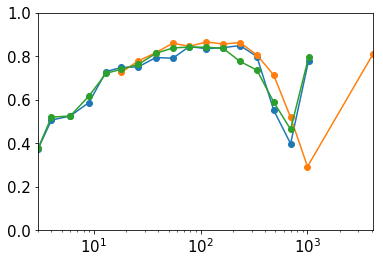

0.8487787384899906
234
0.8651411477985215
113


In [9]:
final5mer_abscov = pd.read_pickle(maindir+'feb15k5merWithAbsCov20190311t15:02:23_optimalValues_perPC')
final5mer =pd.read_pickle(maindir+'stats/feb15_optimalValues_perPC')
final6mer =pd.read_pickle(maindir+'stats/feb15k6mers_optimalValues_perPC')
final5mer['max'].plot(style='-o')
final6mer['max'].plot(style='-o')
final5mer_abscov['max'].plot(style='-o')
plt.xscale('log')
plt.ylim(0,1)
plt.show()
print(final['max'].max())
print(final['max'].astype(float).idxmax())
print(final6mer['max'].max())
print(final6mer['max'].astype(float).idxmax())

In [ ]:
# take optimum conditions, assign final bin numbers to tSNE
# plot completeness in single cluster for all ground truth genomes 
# what correlates best with this completeness (and what worst)?

imp.reload(mock)
tsne_5merOpt, stats5merOpt = mock.make_Opt_tSNE(final,maindir,'stats/feb15_all_tSNEs','feb15_5mer')
tsne_6merOpt, stats6merOpt = mock.make_Opt_tSNE(final6mer,maindir,'stats/feb15k6mers_all_tSNEs','feb15_6mer')    


In [ ]:
stats6merOpt_mod = stats6merOpt.copy()
idx = stats6merOpt_mod[stats6merOpt_mod['num_contigs_idx'].isin(['2571042922','2579779151','2565956510','2517093008','2757320366'])].index
stats6merOpt_mod.loc[idx,'completeness(seqlen)'] = stats6merOpt_mod.loc[idx,'%genome_unclus(seqlen)']  

In [ ]:
stats7merOpt = pd.read_pickle(maindir+'stats/feb15_7mer_OptimalClustering_stats')
stats5merOpt['completeness(seqlen)'].drop(-1).fillna(0).sort_values(ascending=False).plot(style='-o',label='5-mers')
stats6merOpt['completeness(seqlen)'].drop(-1).fillna(0).sort_values(ascending=False).plot(style='-o',label='6-mers')
stats7merOpt['completeness(seqlen)'].drop(-1).fillna(0).sort_values(ascending=False).plot(style='-o',label='7-mers')
plt.ylabel('Recovered sequence length (%)')
plt.xlabel('Ranked clusters')
plt.xticks([])
plt.title('Optimal conditions mock metagenome')
plt.legend()

In [ ]:
stats7merOpt = pd.read_pickle(maindir+'stats/feb15_7mer_OptimalClustering_stats')
stats5merOpt['completeness(seqlen)'].drop(-1).fillna(0).sort_values(ascending=False).plot(style='-o',label='5-mers')
stats6merOpt_mod['completeness(seqlen)'].drop(-1).fillna(0).sort_values(ascending=False).plot(style='-o',label='6-mers')
stats7merOpt['completeness(seqlen)'].drop(-1).fillna(0).sort_values(ascending=False).plot(style='-o',label='7-mers')
plt.ylabel('Recovered sequence length (%)')
plt.xlabel('Ranked clusters')
plt.xticks([])
plt.title('Optimal conditions mock metagenome')
plt.legend()

In [ ]:
stats6merOpt_mod['completeness(seqlen)'].fillna(0).mean()
k6 = list(stats6merOpt_mod['completeness(seqlen)'].drop(-1).fillna(0))
k7 = list(stats7merOpt['completeness(seqlen)'].drop(-1).fillna(0))
pd.DataFrame([k6,k7]).T.median()


In [ ]:
stats6merOpt_mod['completeness(seqlen)'].fillna(0).mean()


In [ ]:
stats7merOpt['completeness(seqlen)'].drop(-1).fillna(0).mean()

In [ ]:
stats6merOpt_mod['completeness(seqlen)'].drop(-1).fillna(0).mean()

In [4]:
stats5merOpt = pd.read_pickle(maindir+'stats/feb15_5mer_OptimalClustering_stats')

In [7]:
final5mer_abscov

,idxmax,max
3,14,0.376089
4,130,0.519513
6,159,0.524723
9,116,0.617013
13,130,0.720933
18,159,0.73958
26,174,0.761948
38,130,0.812748
55,145,0.837867
78,159,0.841611


In [ ]:
imp.reload(mock)
subfolder = 'feb15_5mers_optimal'
savename = 'feb15_5mers'
mock.plot_optimal_clustering(tsne_5merOpt,stats5merOpt,maindir,subfolder,savename)
subfolder = 'feb15_6mers_optimal'
savename = 'feb15_6mers'
mock.plot_optimal_clustering(tsne_6merOpt,stats6merOpt,maindir,subfolder,savename)


In [ ]:
color = sns.color_palette('Paired',15)
sns.palplot([color[0],color[6],color[11]])
final6mer

In [ ]:
def plot_optimal_clustering(tsne_opt,stats_opt,maindir,subfolder,savename)
    color = sns.color_palette('Paired',15)
    subfolder = 'feb15_5mers_optimal'
    savename = 'feb15_5mers'
    if not os.path.isdir(maindir+'plots/'+subfolder):
            os.mkdir(maindir+'plots/'+subfolder)
    for genomeclu in stats5merOpt.index:
        if genomeclu!=-1:
            genome = stats5merOpt.loc[genomeclu,'num_contigs_idx']
            cluster = genomeclu
            f,ax = plt.subplots(figsize=(10,10))
            if len(str(cluster))<5:
                tsne_5merOpt[(tsne_5merOpt.genome!=genome)&(tsne_5merOpt.DBclusternum!=cluster)].plot.scatter(0,1,alpha=.1,ax=ax,color='gray',label=None)
                tsne_5merOpt[(tsne_5merOpt.genome==genome)&(tsne_5merOpt.DBclusternum==cluster)].plot.scatter(0,1,alpha=.4,ax=ax,color='b',label='Correct call')
                tsne_5merOpt[(tsne_5merOpt.genome==genome)&(tsne_5merOpt.DBclusternum==-1)].plot.scatter(0,1,alpha=.3,ax=ax,color=color[6],label='Unclustered, but part of genome')
                try:
                    tsne_5merOpt[(tsne_5merOpt.genome!=genome)&(tsne_5merOpt.DBclusternum==cluster)].plot.scatter(0,1,alpha=.3,ax=ax,color=color[11],label='Incorrect call')
                except ValueError:
                    print('no incorrect calls for cluster '+str(cluster))
            else:
                tsne_5merOpt[(tsne_5merOpt.genome!=genome)&(tsne_5merOpt.DBclusternum!=cluster)].plot.scatter(0,1,alpha=.1,ax=ax,color='gray',label=None)
                #tsne_5merOpt[(tsne_5merOpt.genome==genome)&(tsne_5merOpt.DBclusternum==cluster)].plot.scatter(0,1,alpha=.6,ax=ax,color=color[0],label='Correct call')
                tsne_5merOpt[(tsne_5merOpt.genome==genome)&(tsne_5merOpt.DBclusternum==-1)].plot.scatter(0,1,alpha=.3,ax=ax,color=color[6],label='Unclustered, but part of genome')
                tsne_5merOpt[(tsne_5merOpt.genome==genome)&(tsne_5merOpt.DBclusternum!=-1)].plot.scatter(0,1,alpha=.3,ax=ax,color=color[11],label='Incorrect call')
            if savename=='feb15_5mers':
                plt.xlim(right=30)
            plt.title(savename+' genome '+str(genome)+' cluster '+str(cluster))
            f.savefig(maindir+'plots/'+subfolder+'/'+savename+'_genome_'+str(genome)+'_cluster_'+str(cluster)+'.png')
            plt.close(f)


In [ ]:
tsne_5merOpt.head()

color = sns.color_palette('Paired',12)

In [ ]:
sns.palplot(color)

In [ ]:
stats6merOpt.head()

In [ ]:
import time
    num_genomes = len(statsdf)
    mu, sigma = 5., 1. # mean and standard deviation
    coverage = np.random.lognormal(mu, sigma, num_genomes)
    coverage = pd.DataFrame(coverage)
    coverage.rename(index=str,columns={0:'mean_coverage'},inplace=True)
    coverage.set_index(statsdf.index,inplace=True)
    a=[f for f in time.localtime()]
    b = [str("{0:0=2d}".format(f)) for f in a[1:]]
    timestamp = [str(a[0])+b[0]+b[1]+'_'+b[2]+':'+b[3]+':'+b[4]]
    coverage.to_pickle(maindir+'stats/'+'coverage'+savename+'_'+timestamp[0])
    statsdf['mean_coverage'] = coverage['mean_coverage']
    for genome in contigdf.genome:
        idx = contigdf[contigdf.genome==genome].index
        mu = statsdf.loc[genome,'mean_coverage'] # mean of normal distribution
        contigdf.loc[idx,'coverage_frac'] = np.random.normal(mu,.1*mu,len(idx)) # normal 1
        contigdf.loc[idx,'coverage_log'] = np.random.normal(mu,np.log(mu),len(idx)) # normal 2

statsdf.head()

In [ ]:
statsdf['mean_coverage'].plot.hist(bins=np.logspace(1,4,50))
plt.xscale('log')

In [ ]:
mu = 10
sigma = .1*mu

plt.hist(np.random.normal(mu,sigma,500),100)
plt.show()

In [ ]:
for genome in statsdf.index:
    contigdf[contigdf.genome==genome]['coverage_frac'].plot.hist(100,alpha=.3)
plt.xscale('log')

In [ ]:
for genome in statsdf.index:
    contigdf[contigdf.genome==genome]['coverage_log'].plot.hist(100,alpha=.3)
plt.xscale('log')

In [ ]:
for genome in statsdf.index:
    contigdf[contigdf.genome==genome]['coverage_frac'].plot.density()
plt.xscale('log')

In [ ]:
for genome in statsdf.index:
    contigdf[contigdf.genome==genome]['coverage_log'].plot.density()
plt.xscale('log')
plt.xlim(2,1e3)

In [ ]:
keys = statsdf.index; values = sns.color_palette('deep',len(keys))
lut = dict(zip(keys,values))
colors = contigdf.genome.map(lut)
f,ax = plt.subplots(figsize=(8,8))
contigdf.plot.scatter('GC','coverage_frac',s=contigdf['Sequence length'].astype(float).divide(1e2),color=colors,alpha=.2,ax=ax)
plt.yscale('log')
plt.ylabel('Coverage')


In [ ]:
f,ax = plt.subplots(figsize=(10,10))
contigdf.plot.scatter('GC','coverage_log',s=contigdf['Sequence length'].astype(float).divide(1e2),color=colors,alpha=.4,ax=ax)
plt.yscale('log')

In [ ]:
imp.reload(mock)
contigdf,statsdf = mock.make_coverage(contigdf,statsdf,maindir,'15feb_MockMetaWithCoverage')

how to incorporate the coverage? 
1) as one added dimension to the dimensions of kmers? then the contribution will perhaps end up being drowned out. 
2) Or: add to x PCs after PCA, then rescale etc. 


In [ ]:
perform coverage included tsne analysis

In [ ]:
take real dataset 
use minimetagenome co-occurrence as ground truth

In [ ]:
# ok, so quality measure is there, now sweep through a bunch of parameters. 
# first up, sweep through clustering conditions on a given tsne
# repeat for every tsne (with varying PCs etc)
# compare optimal scores for all 
def minCS_sweep(tsne,maindir,subfolder,savename):
    min_GTgenome_contigs = tsne.groupby('genome').count()[0].min()
    sweep_pct = np.linspace(.1,2,20)
    leafdf = pd.DataFrame(index=[int(f) for f in sweep_pct*1e2],columns=['hom_leaf','com_leaf','val_leaf'])   
    eomdf = pd.DataFrame(index=[int(f) for f in sweep_pct*1e2],columns=['hom_eom','com_eom','val_eom'])       
    eom = [];leaf=[]
    for perc in sweep_pct:
        perc_int = int(perc*1e2)
        savename = subfolder+'15feb_maintSNE_eom_'+str(int(1e2*perc))+'pct_'
        keys = ['min_cluster_size','min_samples','cluster_selection_method','allow_single_cluster',
           'expt_name']
        values = [round(min_GTgenome_contigs*perc),1,'eom',True,savename]
        kwargs = dict(zip(keys,values))
        tsne,stats,QC_eom = cluster_main_tsne(tsne,maindir,**kwargs)
        eomdf.loc[perc_int] = QC_eom
    
        savename = subfolder+'15feb_maintSNE_leaf_'+str(int(1e2*perc))+'pct_'
        keys = ['min_cluster_size','min_samples','cluster_selection_method','allow_single_cluster',
           'expt_name']
        values = [round(min_GTgenome_contigs*perc),1,'leaf',True,savename]
        kwargs = dict(zip(keys,values))
        tsne,stats,QC_leaf = cluster_main_tsne(tsne,maindir,**kwargs)
        leafdf.loc[perc_int] = QC_leaf
    clusterQualdf = eomdf.join(leafdf)
    return(clusterQualdf)
    